# geopandas intersection area example

By [Ben Welsh](http://palewi.re/who-is-ben-welsh/)

How to use geopandas' overlay method to find the area of intersections between two datasets.

This example merges California state Assembly districts with Los Angeles and Orange neighborhoods. It was prompted by a question [posed by Sahil Chinoy](https://twitter.com/sahilchinoy/status/883317188559503361). 

In [118]:
import warnings
import pandas as pd
import geopandas as gpd

In [121]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [71]:
warnings.filterwarnings("ignore")

In [72]:
%matplotlib inline

### Read in LA County neighborhoods from the Los Angeles Times

In [73]:
hoods = gpd.read_file("./input/la-county-neighborhoods-v6.geojson")

In [74]:
hoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 8 columns):
external_id     318 non-null object
geometry        318 non-null object
kind            318 non-null object
metadata        318 non-null object
name            318 non-null object
resource_uri    318 non-null object
set             318 non-null object
slug            318 non-null object
dtypes: object(8)
memory usage: 19.9+ KB


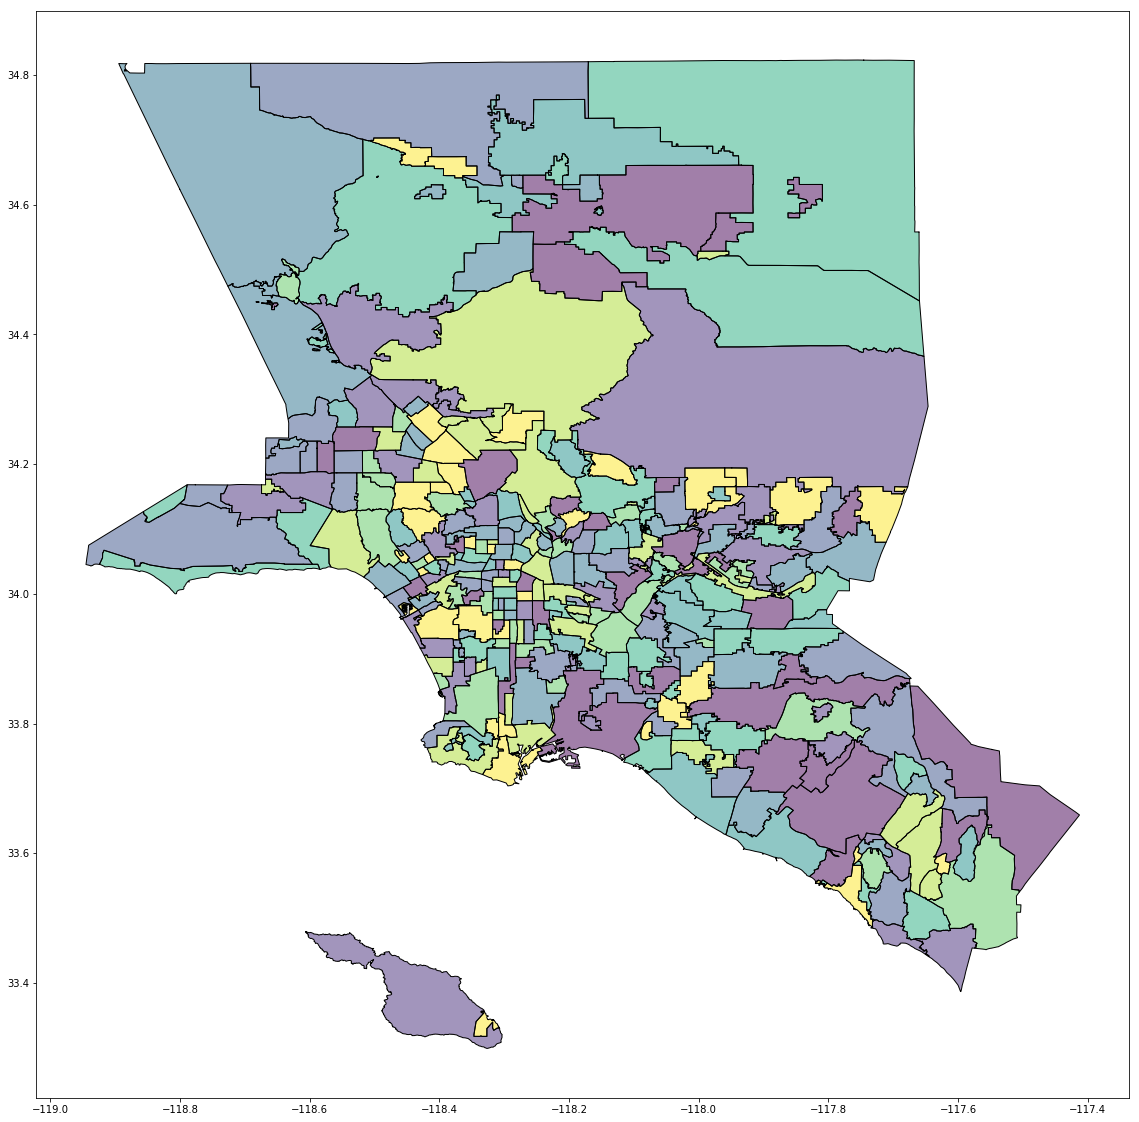

In [136]:
hoods.plot(figsize=(40, 20))

### Read in the state Assembly districts from California's redistricting commission

In [77]:
assembly = gpd.read_file("./input/state-assembly-districts-2011.geojson")

In [78]:
assembly.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
external_id     80 non-null object
geometry        80 non-null object
kind            80 non-null object
metadata        80 non-null object
name            80 non-null object
resource_uri    80 non-null object
set             80 non-null object
slug            80 non-null object
dtypes: object(8)
memory usage: 5.1+ KB


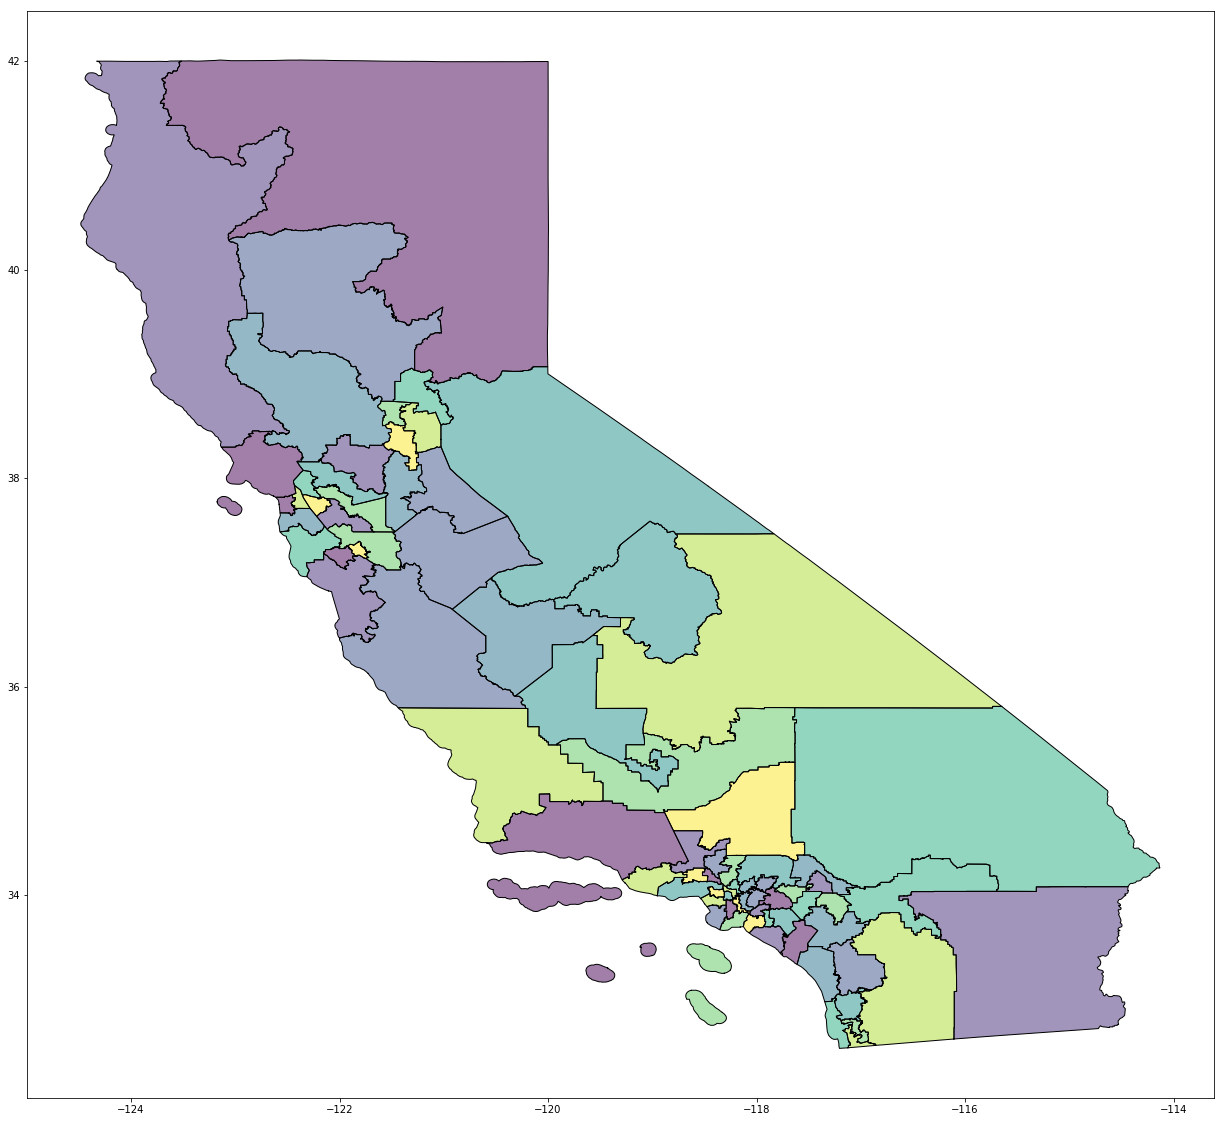

In [135]:
ax = assembly.plot(figsize=(40, 20))

### Calculate the area of each in square miles

In [80]:
def get_sqmi(row):
    feet = row.geometry.area
    return feet / 27878400

The geometries are reprojected into feet using a state plane projection for California. If your data covers another area you should consider finding a more appropriate projection.

In [81]:
assembly['area'] = assembly.to_crs({'init': 'esri:102644'}).apply(get_sqmi, axis=1)

In [82]:
hoods['area'] = hoods.to_crs({'init': 'esri:102644'}).apply(get_sqmi, axis=1)

### Conduct an overlay to return the intersections between the two maps

In [83]:
intersection = gpd.overlay(
    assembly,
    hoods,
    how="intersection"
)

Ring Self-intersection at or near point -117.84450100000018 34.587186000000003
Ring Self-intersection at or near point -117.83449399999986 33.879912000000175
Ring Self-intersection at or near point -118.62894100000015 34.501242000000147
Ring Self-intersection at or near point -118.58397900000013 34.406374999999997


In [84]:
intersection.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3210 entries, 0 to 3209
Data columns (total 17 columns):
external_id       3210 non-null object
kind              3210 non-null object
metadata          3210 non-null object
name              3210 non-null object
resource_uri      3210 non-null object
set               3210 non-null object
slug              3210 non-null object
area              3210 non-null float64
external_id_2     3210 non-null object
kind_2            3210 non-null object
metadata_2        3210 non-null object
name_2            3210 non-null object
resource_uri_2    3210 non-null object
set_2             3210 non-null object
slug_2            3210 non-null object
area_2            3210 non-null float64
geometry          3210 non-null object
dtypes: float64(2), object(15)
memory usage: 451.4+ KB


Give the intersection the same project as our source data

In [86]:
intersection.crs = assembly.crs

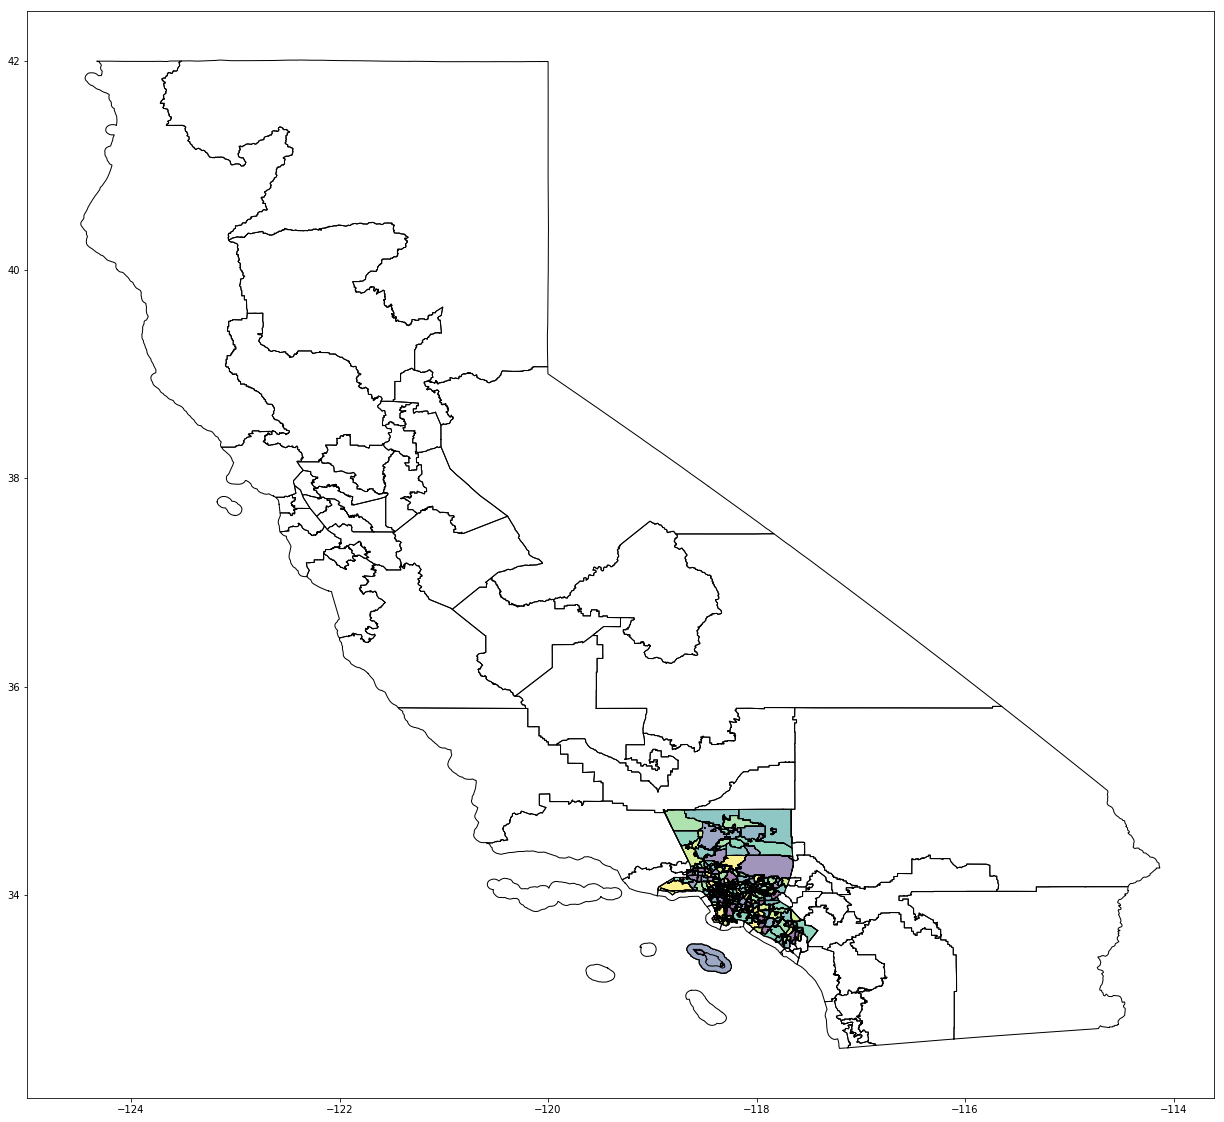

In [127]:
ax = intersection.plot(figsize=(40, 20))
assembly.plot(ax=ax, facecolor='none');
hoods.plot(ax=ax, facecolor='none');

Look at just downtown LA

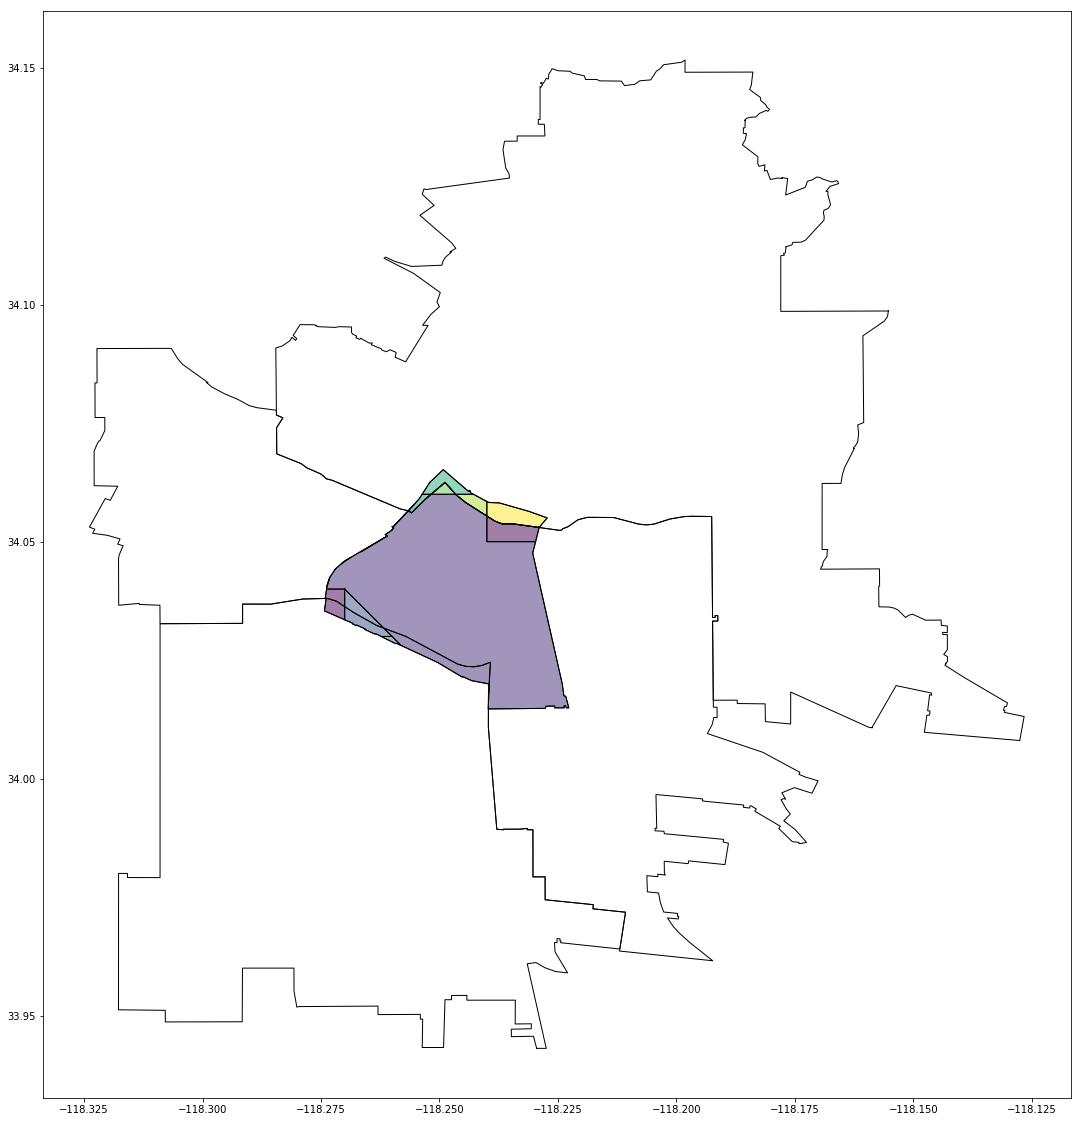

In [155]:
ax = intersection[intersection.name_2 == 'Downtown'].plot(figsize=(40, 20))
assembly[assembly.name.isin(['51', '53', '59'])].plot(ax=ax, facecolor='none');
hoods[hoods.name == 'Downtown'].plot(ax=ax, facecolor='none');

Clean up columns

In [142]:
trimmed = intersection[[
    'name',
    'area',
    'name_2',
    'area_2',
    'geometry'
]]

In [143]:
trimmed.columns = [
    'district_name',
    'district_area',
    'hood_name',
    'hood_area',
    'geometry'
]

### Calculate the area of each intersection in a new column

In [144]:
trimmed['intersection_area'] = trimmed.to_crs({'init': 'esri:102644'}).apply(get_sqmi, axis=1)

### Calculate the percentage of area in the intersections

In [145]:
trimmed['district_percent'] = trimmed.intersection_area / trimmed.district_area

In [146]:
trimmed['hood_percent'] =  trimmed.intersection_area / trimmed.hood_area

### Dissolve the fragments

In [159]:
dissolved = trimmed.dissolve(by=['district_name', 'hood_name'], aggfunc='sum').reset_index()

### Take a look at the result

In [160]:
dissolved.head()

,district_name,hood_name,geometry,district_area,hood_area,intersection_area,district_percent,hood_percent
0,33,Northeast Antelope Valley,(POLYGON ((-117.6603389999982 34.5113779999182...,54820.353778,1331.139694,0.000611,0.000000,0.000001
1,34,Northwest Antelope Valley,(POLYGON ((-118.6908782173556 34.8180114642676...,8319.790038,426.015561,0.008663,0.000002,0.000041
2,34,Ridge Route,"(POLYGON ((-118.881364 34.790629, -118.8813750...",37439.055170,2661.036436,0.010863,0.000003,0.000037
3,36,Acton,"POLYGON ((-118.1185010000001 34.48063, -118.11...",16711.858163,235.998170,39.333025,0.014122,1.000000
4,36,Agua Dulce,"(POLYGON ((-118.361546 34.502986, -118.3615468...",44564.955101,485.287472,5.881098,0.002111,0.193901


Take another peek at downtown

In [161]:
dissolved[dissolved.hood_name == 'Downtown'][[
    'district_name',
    'intersection_area',
    'hood_percent'
]].sort_values("hood_percent", ascending=False)

,district_name,intersection_area,hood_percent
268,53,5.421568,0.927489
243,51,0.324076,0.055441
364,59,0.099121,0.016957


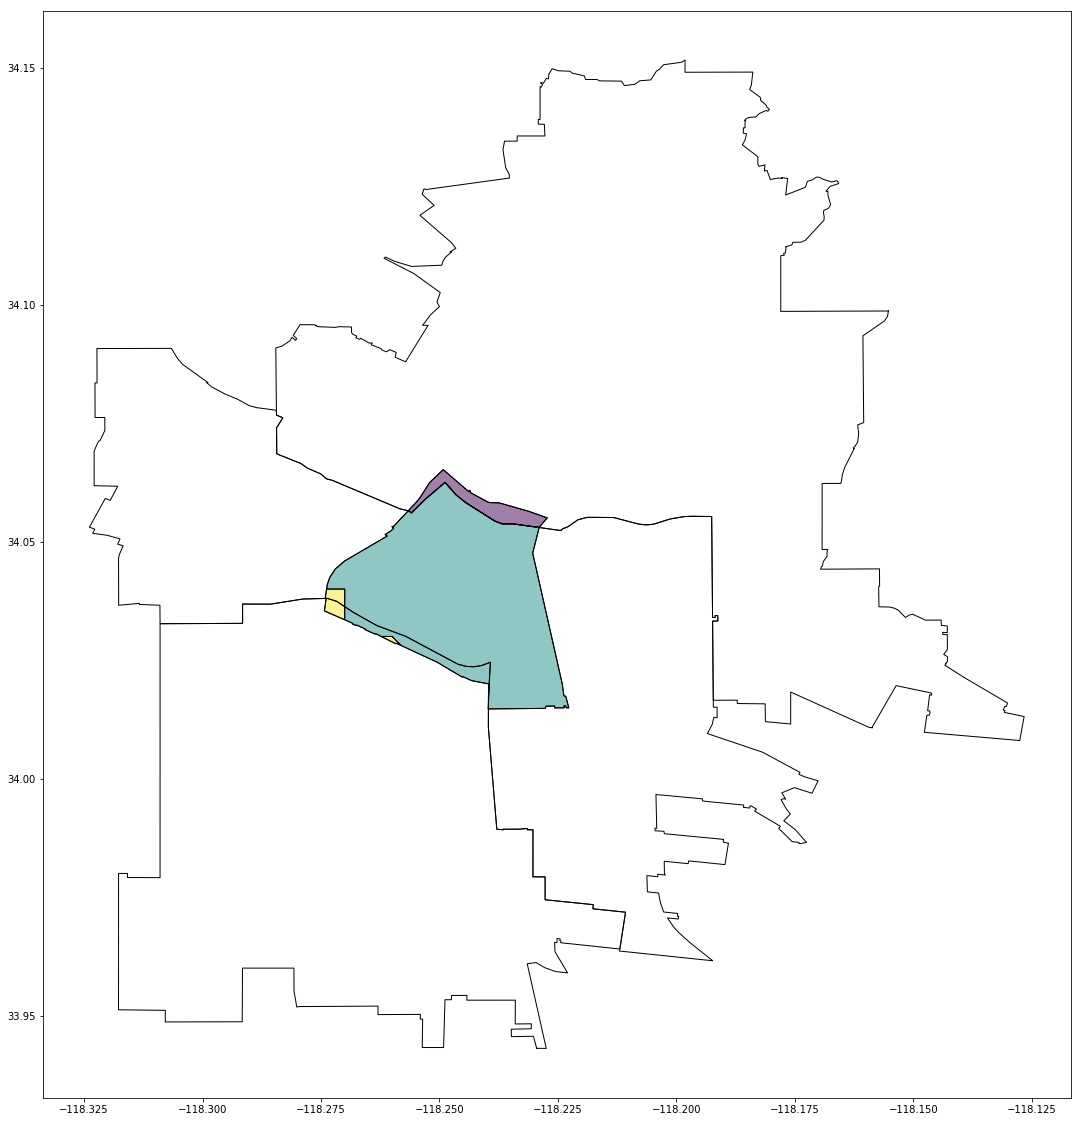

In [162]:
ax = dissolved[dissolved.hood_name == 'Downtown'].plot(figsize=(40, 20))
assembly[assembly.name.isin(['51', '53', '59'])].plot(ax=ax, facecolor='none');
hoods[hoods.name == 'Downtown'].plot(ax=ax, facecolor='none');

### Write it out

In [163]:
dissolved.to_file("./output/intersection-area.shp")